## Introduction to Linear Regression

In this notebook, we'll see how we can use the _statsmodels_ library to perform linear regression in Python.

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

We'll be using a dataset on possums in Australia and New Guinea, borrowed from the OpenIntro Statistics textbook.

You can read more about it here: https://www.openintro.org/data/index.php?data=possum

Our goal will be to understand the relationship between the total length in cm (`total_l`) and the other variables in our dataset.

In [2]:
possum = pd.read_csv('../data/possum.csv')

In [3]:
possum.head()

,site,pop,sex,age,head_l,skull_w,total_l,tail_l
0,1,Vic,m,8.0,94.1,60.4,89.0,36.0
1,1,Vic,f,6.0,92.5,57.6,91.5,36.5
2,1,Vic,f,6.0,94.0,60.0,95.5,39.0
3,1,Vic,f,6.0,93.2,57.1,92.0,38.0
4,1,Vic,f,2.0,91.5,56.3,85.5,36.0


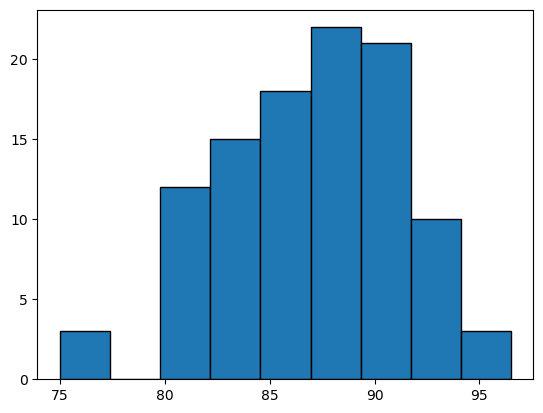

In [4]:
plt.hist(possum['total_l'], bins = 'fd', edgecolor = 'black');

Let's say that we wanted to estimate what the average total length of a possum is? What would be our best guess?

We could use the sample mean. 

In [5]:
possum['total_l'].mean()

np.float64(87.08846153846154)

How do we measure how well the sample mean does? We could compare the observed values to this estimate. This is the same as calculating the **deviation**.

In [6]:
possum['total_l'] - possum['total_l'].mean()

0      1.911538
1      4.411538
2      8.411538
3      4.911538
4     -1.588462
         ...   
99    -5.588462
100   -4.588462
101    1.911538
102   -4.588462
103    1.911538
Name: total_l, Length: 104, dtype: float64

Ideally, we'd like these deviation values to be as small as possible. 

If we want an overall measure of how well this estimate does, we could sum up all of the deviations, but recall that this will result in a total of 0. The normal fix for this is to instead look at the total of the squared deviations.

In [7]:
TSS = ((possum['total_l'] - possum['total_l'].mean())**2).sum()
TSS

np.float64(1913.8261538461538)

We could also look at the mean of the squared deviations, a quantity called the **mean squared error (MSE)**.

In [8]:
MSE = ((possum['total_l'] - possum['total_l'].mean())**2).mean()
MSE

np.float64(18.40217455621302)

**Question:** If we had more information about a possum, could we make a better estimate for the average? Let's say that we knew the head length of a possum. Would this allow us to make a better guess?

Let's plot the total length (`total_l`) vs. the length of the head in mm (`head_l`).

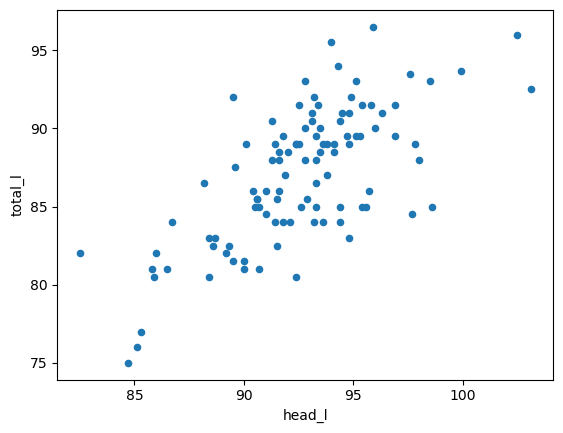

In [9]:
possum.plot(
    kind = 'scatter',
    x = 'head_l',
    y = 'total_l'
);

**Question:** How would you describe this relationship?





It appears that this is a positive relationship - possums which have larger head lengths tend to have larger total lengths.

So, if I knew that a possum had a head length of 100 mm, I'd probably be better off estimating that the total length is going to be larger than the overall average.

Can we do better than just saying that there is a positive relationship? What if we wanted to estimate the effect of head length on total length?

With linear regression, we assume that the average of our target variable is a linear function of the predictor variable(s). So in this case, we would assume that the average total length of a possum is a linear function of the head length.

$$Average\ Total\ Length = \beta_0 + \beta_1\cdot(Head\ Length)$$

for some constants $\beta_0$ and $\beta_1$.

How do we figure out the value of these constants? For that, we'll make use of the [statsmodels](https://www.statsmodels.org/stable/index.html) library. Specifically, we'll be using the formula api.

In [10]:
import statsmodels.formula.api as sm

We'll use the [ols class](https://www.statsmodels.org/devel/generated/statsmodels.formula.api.ols.html). 

For this, we need to specify the following:
* **formula:** A formula specifying the model. These use the [patsy formulas](https://patsy.readthedocs.io/en/latest/formulas.html), which look like "target ~ predictors".
* **data:** The dataset, as a _pandas_ DataFrame.

In [11]:
lr = sm.ols(
    formula = 'total_l ~ head_l',
    data = possum
).fit()                                                  # We can go ahead and tell it to fit the model

We can get the value for our coefficients using the params attribute.

In [12]:
lr.params

Intercept    9.888233
head_l       0.833670
dtype: float64

Filling in the coefficients, we get

$$Average\ Total\ Length = 9.888233 + 0.833670\cdot(Head\ Length)$$

How do we interpret the coefficient for head length? It says that for every one mm increase in head length, the average total length increases by 0.8337.

What do we estimate the average total length of a possum whose head length is 85 mm?

In [13]:
9.888233 + 0.83367 * 85

80.750183

What about a head length of 100 mm?

In [14]:
9.888233 + 0.83367 * 100

93.255233

We can generate predictions from our model using the `predict` method and giving it our dataframe.

In [15]:
lr.predict(possum)

0      88.336561
1      87.002690
2      88.253194
3      87.586259
4      86.169020
         ...    
99     84.501680
100    83.751378
101    86.919323
102    86.169020
103    87.919727
Length: 104, dtype: float64

And if we want to plot the results against the original data, we can do so.

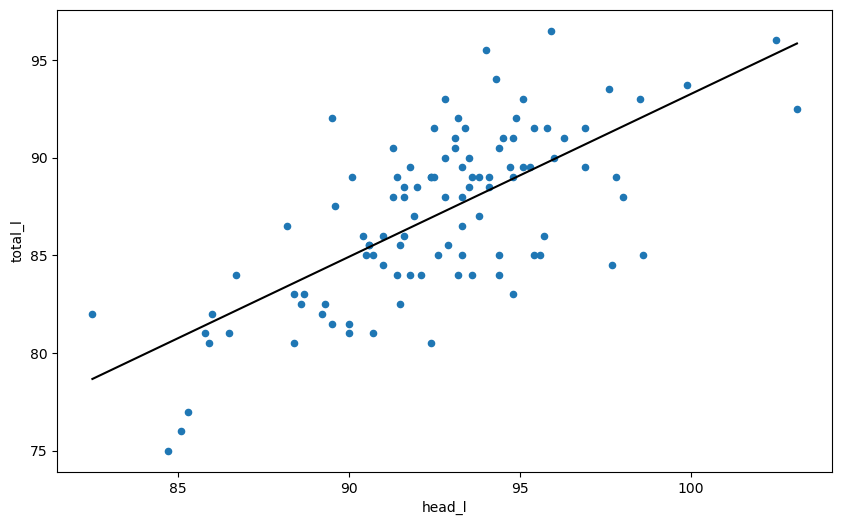

In [16]:
x_pred = pd.DataFrame({'head_l': np.linspace(start = possum['head_l'].min(),
                                             stop = possum['head_l'].max(), 
                                             num = 250)
                      })

pred = lr.predict(x_pred)

possum.plot(
    kind = 'scatter',
    x = 'head_l',
    y = 'total_l',
    figsize = (10,6)
)

plt.plot(x_pred['head_l'], pred, color = 'black');

How far off are the observed values from our predictions? This is what is known as the **residual** of the model.

In [17]:
resid = possum['total_l'] - lr.predict(possum)
resid

0      0.663439
1      4.497310
2      7.246806
3      4.413741
4     -0.669020
         ...   
99    -3.001680
100   -1.251378
101    2.080677
102   -3.669020
103    1.080273
Length: 104, dtype: float64

**Fact:** The coefficients that statsmodels chose are the ones that minimize the total squared residuals.

In [18]:
RSS = (resid**2).sum()
RSS

np.float64(999.7626903179405)

We can also look at the mean squared error for the model predictions.

In [19]:
MSE_model = (resid**2).mean()
MSE_model

np.float64(9.613102791518658)

Note that by using this model, we have reduced the difference between our observed values and the estimated mean.

In [20]:
print(f'Total Sum of Squares: {TSS}')
print(f'Residual Sum of Squares: {RSS}')

Total Sum of Squares: 1913.8261538461538
Residual Sum of Squares: 999.7626903179405


If we calculate the reduction in the total sum of squares as a percentage of the total sum of squares, we get the **R^2** value of the model.

In [21]:
(TSS - RSS) / TSS

np.float64(0.47761049857702587)

Note that a perfect model (one with zero residuals), would have an R^2 value of 1.

The R^2 value is also contained in our model, so we don't have to calculate it by hand.

In [22]:
lr.rsquared

np.float64(0.477610498577026)

### Inference for Our Model

Something very important to keep in mind is that the coefficients that statsmodels gave us are just an **estimate** based on the sample that we have. 

There are at least two questions we should now be asking:

1. What is the uncertainty in the estimate for these coefficients?

2. Do we have enough evidence to conclude that the total length of a possum is linearly related to the length of the head? That is, do we have enough evidence to conclude that the coefficient should be nonzero?

Let's tackle the first question. Specifically, we'll look at the uncertainty in our estimate for the coefficient for the head length. We can do this using the bootstrap. The procedure will be as follows:

1. Resample the pairs of points (head_l, total_l).
2. Fit a linear model on the resampled points.
3. Record the coefficinent for the head length.
4. Find the 2.5th and 97.5th percentiles for the resample coefficients.

In [23]:
resample_coefficients = []
num_resamples = 1000

for _ in range(num_resamples):
    resample = possum.sample(n=len(possum), replace=True)
    lr_resample = sm.ols(
        formula = 'total_l ~ head_l',
        data = resample
    ).fit()
    resample_coefficients.append(lr_resample.params['head_l'])

np.quantile(resample_coefficients, 0.025), np.quantile(resample_coefficients, 0.975)

(np.float64(0.6588191103516521), np.float64(1.0185075484583024))

What about the second question? Do we have enough evidence to conclude that there is a linear relationship? For this, we can use a permutation-based approach.

Our null hypothesis is that there is no linear relationship between our variables (so that the slope is zero), and our alternate is that there is a linear relationship between the variables (so that the slope is nonzero).

What we can do is to randomly permute the values of the predictor variable, fit a regression line, and save the slope. Then we'll compare our observed slope to the permutation slopes.

In [24]:
num_permutations = 1000
possum_copy = possum.copy()
permutation_slopes = []

for _ in range(num_permutations):
    possum_copy['head_l'] = np.random.choice(possum_copy['head_l'], len(possum_copy), replace=False)
    lr_permute = sm.ols(
        formula = 'total_l ~ head_l',
        data = possum_copy
    ).fit()
    permutation_slopes.append(lr_permute.params['head_l'])

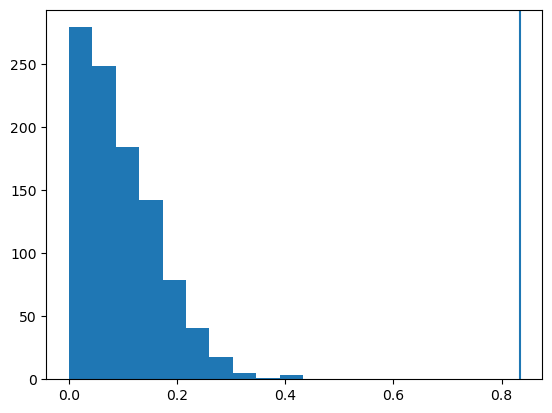

In [25]:
plt.hist(np.abs(permutation_slopes))
ymin, ymax = plt.ylim()
plt.vlines(np.abs(lr.params['head_l']), ymin, ymax)
plt.ylim(ymin, ymax);

In [26]:
(np.abs(permutation_slopes) >= np.abs(lr.params['head_l'])).mean()

np.float64(0.0)

Based on this, we can reject the null hypothesis and conclude that there is a linear relationship between head length and total length.

## Analytical Approach to Inference

Statsmodels can also calculate confidence intervals and p-values. However, these are build off of assumptions about our model, and if these assumptions are violated, we can get inaccurate estimates.

The four assumptions of the linear regression model are as follows:
* **L**inear Function: The mean of the response at each value of the predictor is a linear function of the predictor variable.
* **I**ndependent: The residuals are independent.
* **N**ormally Distributed: The residuals at each value of the predictor are normally distributed.
* **E**qual variances: The residuals at each value of the predictor have equal variances.

If the linearity assumption is violated, we can sometimes modify our model to correct for it, a topic we'll visit later.

The independence assumption is usually about how the data was collected; is the data a representative sample of the population of interest?

If the residuals are not normally distributed, this can often be overcome by large sample sizes. However, if we are trying to estimate a typical range of values for the target variable, we do want to make sure that the residuals are at least approximately normally distributed.

If the equal variance assumption is violated, this can seriously affect the inference on the model, so if using the built-in confidence intervals or p-values from statsmodels, it is important to check this assumption first.

## Diagnostics

Based on the plots above, the first assumption that the mean response is a linear function of the predictor variables looks reasonable. We'll also assume that the data we have is a representative sample.

Now, let's take a look at the residuals to check the other three assumptions. A common way to do this is to look at the residuals vs. the fitted values. What we want to see is a lack of any kind of pattern in the residuals.

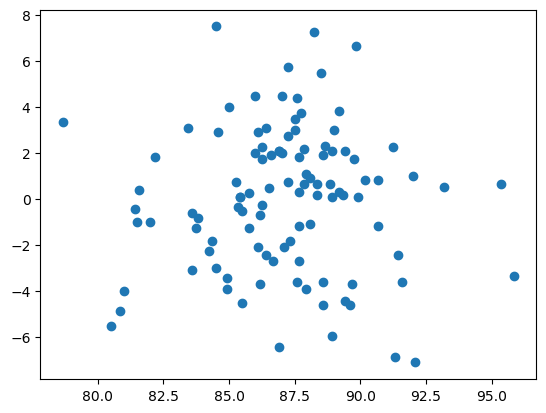

In [27]:
plt.scatter(x = lr.fittedvalues, y = lr.resid);

There don't appear to be any patterns in the residual plot. Let's check a histogram and QQ-plot.

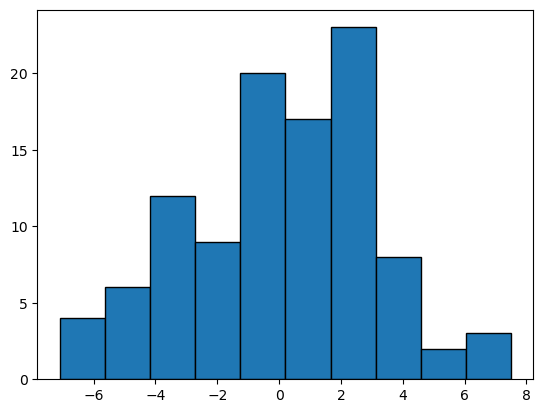

In [28]:
plt.hist(lr.resid, edgecolor = 'black');

In [29]:
from scipy.stats import probplot

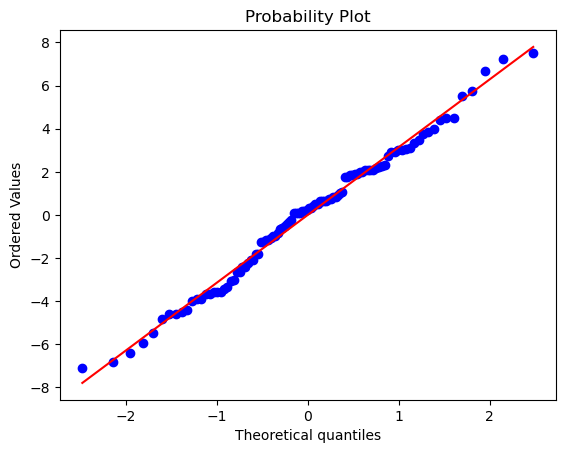

In [30]:
probplot(lr.resid, plot = plt);

If we want to be extra sure, we can use a [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test). This test has the null hypothesis that the data comes from a normal distribution. 

In [31]:
import statsmodels.api as stats

In [32]:
stats.stats.diagnostic.kstest_normal(lr.resid)

(np.float64(0.07748222026875029), np.float64(0.14545874373480344))

The second value is the p-value. In this case, since the p-value is large, we don't have enough evidence to reject the null hypothesis. It looks like a normal distribution is a reasonable model for the residuals.

We also need that the residuals have constant variance. We can test that using a [Breusch-Pagan test](https://en.wikipedia.org/wiki/Breusch%E2%80%93Pagan_test) for homoskedasticity. Here, the null hypothesis is that the variance of the residuals does not depend on the value of the predictors.

In [33]:
stats.stats.diagnostic.het_breuschpagan(lr.resid, lr.model.exog)

(np.float64(0.3834247254673908),
 np.float64(0.5357760562627394),
 np.float64(0.37744271989354694),
 np.float64(0.5403430049151364))

Here, we need to pay attention to the second output value, which is the p-value for the test. Again, the p-value is large, so there is not enough evidence to conclude that the variance depends on the value of the predictors.

We don't see any major violations of the assumptions, so we can feel good about using the estimates from statsmodels.

If we want to look at a confidence interval for our coefficients, which we can access using the `conf_int` method.

In [34]:
lr.conf_int(alpha=0.05)

,0,1
Intercept,-5.980050,25.756517
head_l,0.662438,1.004902


Also, if we want to perform a hypothesis test to check if the coefficient is non-zero, we can access the p-values through the `pvalues` attribute.

In [35]:
lr.pvalues

Intercept    2.192959e-01
head_l       4.680579e-16
dtype: float64

## Confidence Intervals for the Estimated Means

We've seen how we can perform inference on the coefficients of our model, but something else we might ask is how much uncertainty there is about the mean estimates themselves.

This calculation is a little more difficult, although possible, through the simulation-based approaches, so we'll just let statsmodels do the work for us. We can use the `get_prediction` method, and then look at the mean_ci_lower and mean_ci_upper columns.

In [36]:
x_pred = pd.DataFrame({'head_l': np.linspace(start = possum['head_l'].min(),
                                    stop = possum['head_l'].max(), num = 250)})

lr.get_prediction(x_pred).summary_frame()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,78.665992,0.924620,76.832013,80.499970,72.191006,85.140977
1,78.734962,0.917886,76.914340,80.555584,72.263747,85.206177
2,78.803932,0.911158,76.996654,80.611210,72.336459,85.271406
3,78.872903,0.904437,77.078956,80.666849,72.409142,85.336663
4,78.941873,0.897722,77.161245,80.722501,72.481796,85.401950
...,...,...,...,...,...,...
245,95.563709,0.929777,93.719501,97.407916,89.085818,102.041599
246,95.632679,0.936521,93.775094,97.490264,89.150968,102.114390
247,95.701649,0.943271,93.830675,97.572623,89.216088,102.187210
248,95.770619,0.950027,93.886245,97.654994,89.281180,102.260059


As we'll see from the plot, the width of the confidence interval actually changes across values of head length.

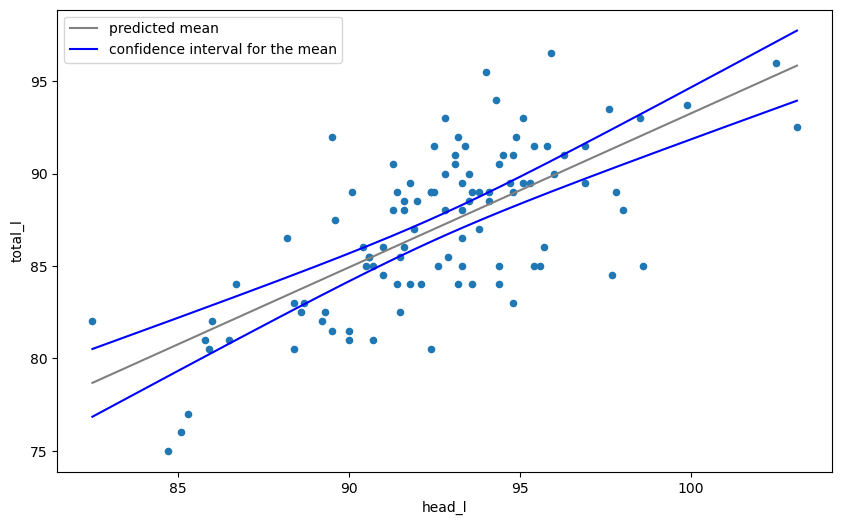

In [37]:
x_pred = pd.DataFrame({'head_l': np.linspace(start = possum['head_l'].min(),
                                    stop = possum['head_l'].max(), num = 250)})

pred = lr.get_prediction(x_pred).summary_frame()

possum.plot(
    kind = 'scatter',
    x = 'head_l',
    y = 'total_l',
    figsize = (10,6)
)

plt.plot(x_pred['head_l'], pred['mean'], color = 'grey', label = 'predicted mean')

plt.plot(x_pred['head_l'], pred['mean_ci_lower'], color = 'blue', label = 'confidence interval for the mean')
plt.plot(x_pred['head_l'], pred['mean_ci_upper'], color = 'blue')

plt.legend();

Something else we can ask is about the distribution of total length values, given a value of the head length.

Our model is assuming that the distribution of total lengths is normal, given a head length value. Statsmodels allows us to create a **prediction interval**, which tells us what we can expect for a new observation. This is actually already a part of the output of get_prediction, in the obs_ci_lower and obs_ci_upper columns.

In [38]:
x_pred = pd.DataFrame({'head_l': np.linspace(start = possum['head_l'].min(),
                                    stop = possum['head_l'].max(), num = 250)})

lr.get_prediction(x_pred).summary_frame()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,78.665992,0.924620,76.832013,80.499970,72.191006,85.140977
1,78.734962,0.917886,76.914340,80.555584,72.263747,85.206177
2,78.803932,0.911158,76.996654,80.611210,72.336459,85.271406
3,78.872903,0.904437,77.078956,80.666849,72.409142,85.336663
4,78.941873,0.897722,77.161245,80.722501,72.481796,85.401950
...,...,...,...,...,...,...
245,95.563709,0.929777,93.719501,97.407916,89.085818,102.041599
246,95.632679,0.936521,93.775094,97.490264,89.150968,102.114390
247,95.701649,0.943271,93.830675,97.572623,89.216088,102.187210
248,95.770619,0.950027,93.886245,97.654994,89.281180,102.260059


Let's display both confidence bands over a range of head_l values.

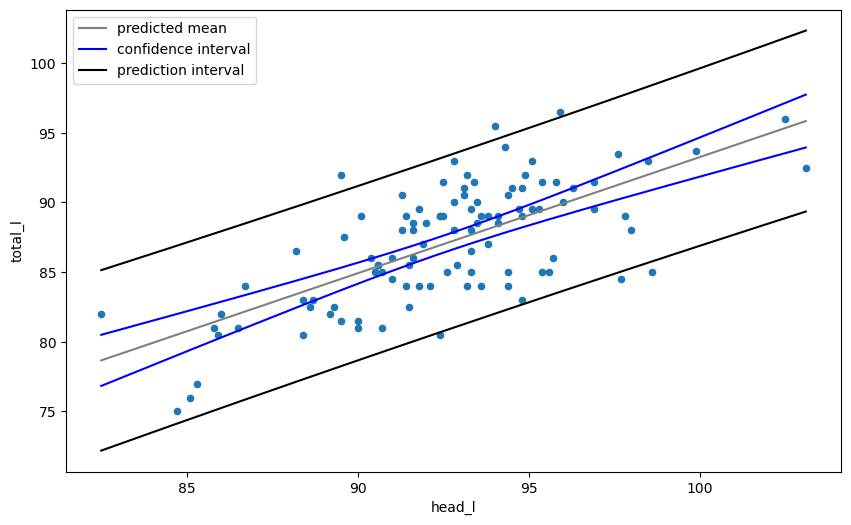

In [39]:
x_pred = pd.DataFrame({'head_l': np.linspace(start = possum['head_l'].min(),
                                    stop = possum['head_l'].max(), num = 250)})

pred = lr.get_prediction(x_pred).summary_frame()

possum.plot(
    kind = 'scatter',
    x = 'head_l',
    y = 'total_l',
    figsize = (10,6)
)

plt.plot(x_pred['head_l'], pred['mean'], color = 'grey', label = 'predicted mean')

plt.plot(x_pred['head_l'], pred['mean_ci_lower'], color = 'blue', label = 'confidence interval')
plt.plot(x_pred['head_l'], pred['mean_ci_upper'], color = 'blue')

plt.plot(x_pred['head_l'], pred['obs_ci_lower'], color = 'black', label = 'prediction interval')
plt.plot(x_pred['head_l'], pred['obs_ci_upper'], color = 'black')

plt.legend();

Note that the prediction interval is much wider than the confidence interval for the mean.

## Categorical Predictors

Let's investigate whether the sex of the possum makes a statistically significant differene on the average total length.

**Null Hypothesis:** The average value of the total length does not depend linearly on the sex of the possum ($\beta_1 = 0$).

**Alternative Hypothesis:** The average value of the total length does depend linearly on the sex of the possum ($\beta_1 \neq 0$).

Before fitting our model, let's look at a boxplot.

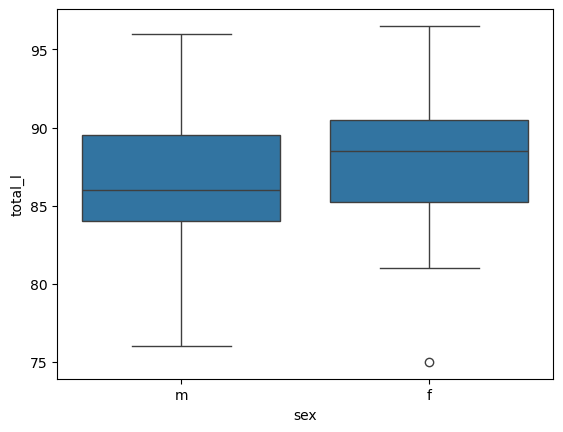

In [40]:
sns.boxplot(data = possum,
           x = 'sex', y = 'total_l');

In [41]:
possum.groupby('sex')['total_l'].describe()

,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
f,43.0,87.906977,4.182241,75.0,85.25,88.5,90.5,96.5
m,61.0,86.511475,4.339896,76.0,84.00,86.0,89.5,96.0


There are differences in the average values, but are these differences statistically significant?

Notice that we are using a categorical predictor variable in this case. Statsmodels allows for fitting models using categorical predictors in the same way as we used numeric predictors.

In [42]:
lr_sex = sm.ols('total_l ~ sex', data = possum).fit()
lr_sex.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                total_l   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     2.687
Date:                Mon, 15 Sep 2025   Prob (F-statistic):              0.104
Time:                        20:29:10   Log-Likelihood:                -297.67
No. Observations:                 104   AIC:                             599.3
Df Residuals:                     102   BIC:                             604.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     87.9070      0.652    134.819      0.000      86.614      89.200
sex[T.m]      -1.3955      0.851     -1.639      0.104      -3.084       0.293
==============================================================================
Omnibus:                        1.500   Durbin-Watson:                   0.993
Prob(Omnibus):                  0.472   Jarque-Bera (JB):                1.309
Skew:                          -0.275   Prob(JB):                        0.520
Kurtosis:                       2.977   Cond. No.                         2.87
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

When we read the output, `sex[T.m]` is an indicator variable which is equal to 1 if the sex variable is m and 0 if the sex variable is f.

**Question:** Looking at the summary output, what conclusion can we reach about the sex variable?

This says that Average Total Length =  87.9070 - 1.3955*(sex[T.m])

So, for female possums, Average Total Length = 87.9070 - 1.3955*(0) = 87.9070

For male possums, Average Average Total Length = 87.9070 - 1.3955*(1) = 86.5115

Let's compare this to the group means.

In [43]:
possum.groupby('sex')['total_l'].mean()

sex
f    87.906977
m    86.511475
Name: total_l, dtype: float64

But now, we should as whether the coefficient we found was statistically significant.

First, a confidence-interval based approach.

In [44]:
resample_coefficients = []
num_resamples = 1000

for _ in range(num_resamples):
    resample = possum.sample(n=len(possum), replace=True)
    lr_resample = sm.ols(
        formula = 'total_l ~ sex',
        data = resample
    ).fit()
    resample_coefficients.append(lr_resample.params['sex[T.m]'])

np.quantile(resample_coefficients, 0.025), np.quantile(resample_coefficients, 0.975)

(np.float64(-2.9834064025679177), np.float64(0.1779366708560183))

Based on this, we can't exclude the possibility that the coefficient should be zero. If we want to do a hypothesis test approach, we can do that, too.

In [45]:
num_permutations = 1000
possum_copy = possum.copy()
permutation_slopes = []

for _ in range(num_permutations):
    possum_copy['sex'] = np.random.choice(possum_copy['sex'], len(possum_copy), replace=False)
    lr_permute = sm.ols(
        formula = 'total_l ~ sex',
        data = possum_copy
    ).fit()
    permutation_slopes.append(lr_permute.params['sex[T.m]'])

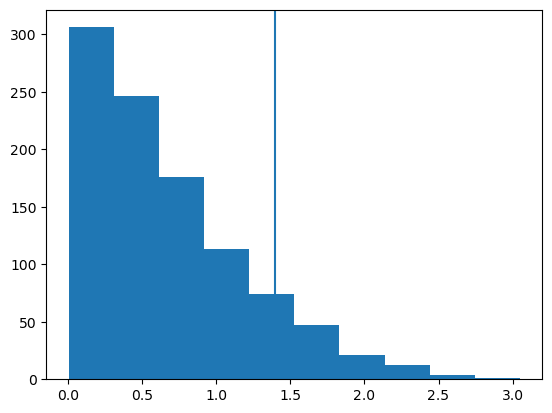

In [46]:
plt.hist(np.abs(permutation_slopes))
ymin, ymax = plt.ylim()
plt.vlines(np.abs(lr_sex.params['sex[T.m]']), ymin, ymax)
plt.ylim(ymin, ymax);

In [47]:
(np.abs(permutation_slopes) >= np.abs(lr_sex.params['sex[T.m]'])).mean()

np.float64(0.117)

Alternatively, we can use the built-in methods. First, let's check the assumptions.

In [48]:
stats.stats.diagnostic.kstest_normal(lr_sex.resid)

(np.float64(0.06683427347083915), np.float64(0.32267914619213245))

In [49]:
stats.stats.diagnostic.het_breuschpagan(lr_sex.resid, lr_sex.model.exog)

(np.float64(0.08247456245499496),
 np.float64(0.7739715532159193),
 np.float64(0.0809527106711714),
 np.float64(0.7765872890085476))

In [50]:
lr_sex.conf_int(alpha=0.05)

,0,1
Intercept,86.613667,89.200286
sex[T.m],-3.084208,0.293205


In [51]:
lr_sex.pvalues['sex[T.m]']

np.float64(0.10427198461172746)

Let's compare our findings here to a standard test of difference in means.

In [52]:
from scipy.stats import ttest_ind

In [53]:
t_results = ttest_ind(
    possum.loc[possum['sex'] == 'm', 'total_l'],
    possum.loc[possum['sex'] == 'f', 'total_l'],
    equal_var = False,
    alternative="two-sided"
)
t_results

TtestResult(statistic=np.float64(-1.6497359086025631), pvalue=np.float64(0.10238492510062482), df=np.float64(92.60930539267096))

Notice that the p-values are slightly different. This is because linear regression assumes equal variance across groups. Let's modify that parameter can see the difference.

In [54]:
t_results = ttest_ind(
    possum.loc[possum['sex'] == 'm', 'total_l'],
    possum.loc[possum['sex'] == 'f', 'total_l'],
    equal_var = True,
    alternative="two-sided"
)
t_results

TtestResult(statistic=np.float64(-1.6391065370655322), pvalue=np.float64(0.10427198461172746), df=np.float64(102.0))

## Violation of Model Assumptions

Now, let's see what can happen when the model assumptions are violated.

In [55]:
cars = pd.read_csv('../data/auto-mpg.csv')

In [56]:
cars.head(2)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320


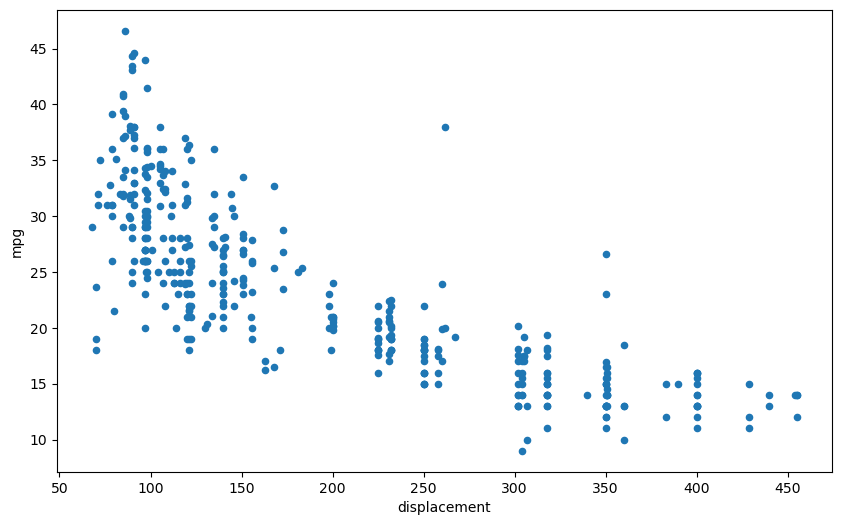

In [57]:
cars.plot(kind = 'scatter', x = 'displacement', y = 'mpg', figsize = (10,6));

In [58]:
lr_cars = sm.ols('mpg ~ displacement', data = cars).fit()
lr_cars.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     725.0
Date:                Mon, 15 Sep 2025   Prob (F-statistic):           1.66e-91
Time:                        20:29:17   Log-Likelihood:                -1175.5
No. Observations:                 398   AIC:                             2355.
Df Residuals:                     396   BIC:                             2363.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       35.1748      0.492     71.519      0.000      34.208      36.142
displacement    -0.0603      0.002    -26.926      0.000      -0.065      -0.056
==============================================================================
Omnibus:                       41.373   Durbin-Watson:                   0.919
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.024
Skew:                           0.711   Prob(JB):                     9.24e-14
Kurtosis:                       4.264   Cond. No.                         463.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

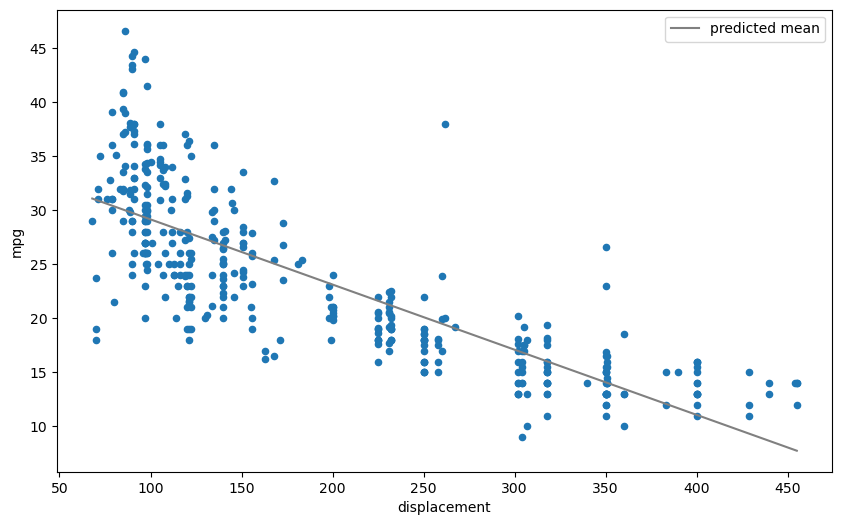

In [59]:
var = 'displacement'

x_pred = pd.DataFrame({
    var: np.linspace(start = cars[var].min(),
                               stop = cars[var].max(), num = 250)
})

pred = lr_cars.get_prediction(x_pred).summary_frame()

cars.plot(kind = 'scatter', x = var, y = 'mpg', figsize = (10,6))

plt.plot(x_pred[var], pred['mean'], color = 'grey', label = 'predicted mean')

plt.legend();

If we plot the residuals against the values of the predictor, we can see a pattern. This is indicative that the assumption of linearity may not be correct and a different model or some kind of transformation might be appropriate.

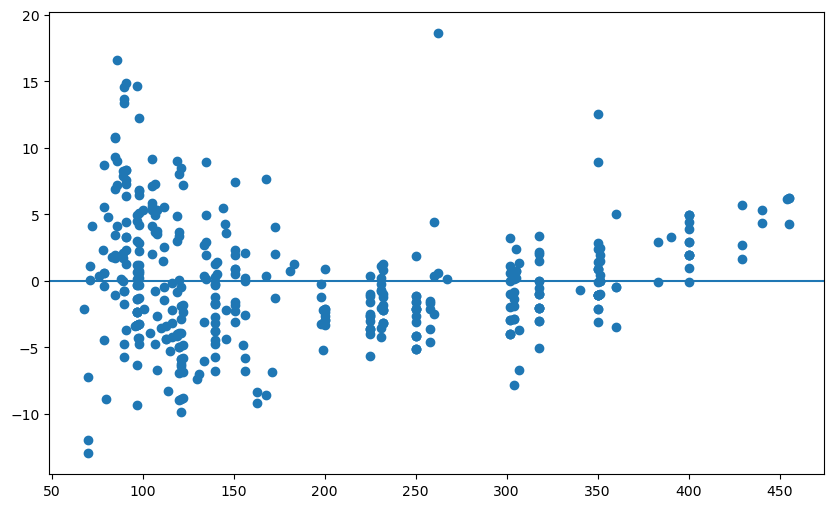

In [60]:
plt.figure(figsize = (10,6))
plt.scatter(cars['displacement'], lr_cars.resid)
xmin, xmax = plt.xlim()
plt.hlines(y = 0, xmin = xmin, xmax = xmax)
plt.xlim(xmin, xmax);

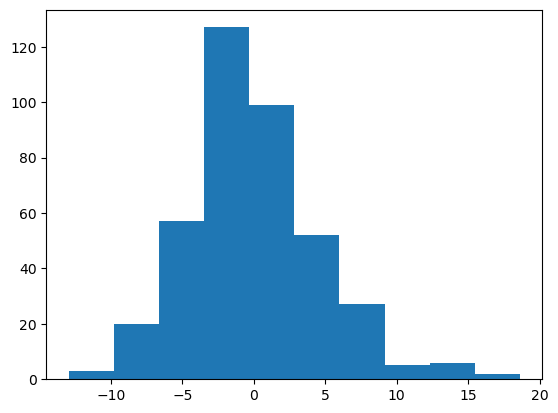

In [61]:
plt.hist(lr_cars.resid);

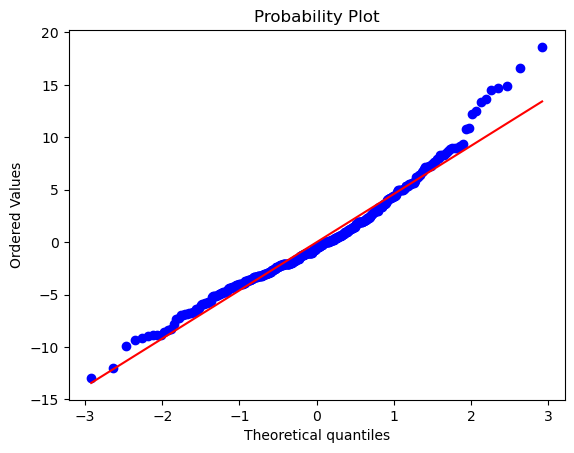

In [62]:
probplot(lr_cars.resid, plot = plt);

In [63]:
stats.stats.diagnostic.kstest_normal(lr_cars.resid)

(np.float64(0.07575178910836489), np.float64(0.0009999999999998899))

In [64]:
stats.stats.diagnostic.het_breuschpagan(lr_cars.resid, lr_cars.model.exog)

(np.float64(19.374473449789168),
 np.float64(1.0743352954554427e-05),
 np.float64(20.263534675069142),
 np.float64(8.885071474612875e-06))

Let's see how our confidence and prediction intervals look inaccurate when the assumptions are not met.

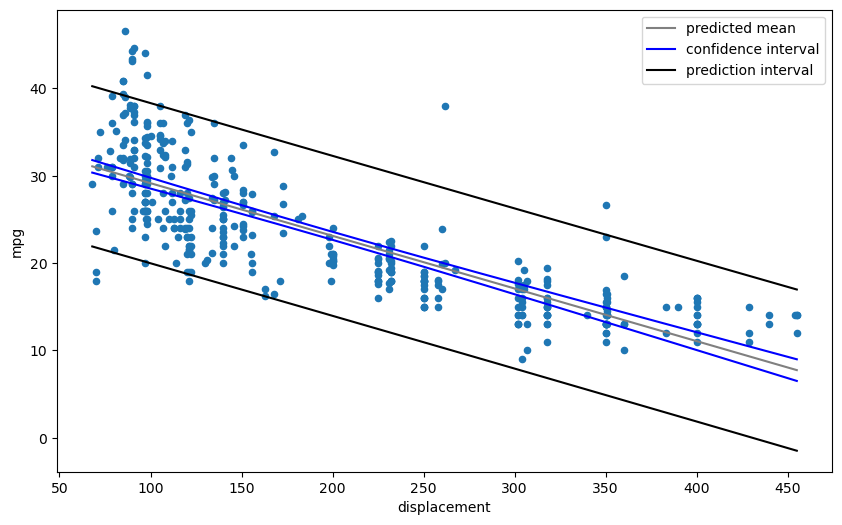

In [65]:
var = 'displacement'

x_pred = pd.DataFrame({
    var: np.linspace(start = cars[var].min(),
                               stop = cars[var].max(), num = 250)
})

pred = lr_cars.get_prediction(x_pred).summary_frame()

cars.plot(kind = 'scatter', x = var, y = 'mpg', figsize = (10,6))

plt.plot(x_pred[var], pred['mean'], color = 'grey', label = 'predicted mean')

plt.plot(x_pred[var], pred['mean_ci_lower'], color = 'blue', label = 'confidence interval')
plt.plot(x_pred[var], pred['mean_ci_upper'], color = 'blue')

plt.plot(x_pred[var], pred['obs_ci_lower'], color = 'black', label = 'prediction interval')
plt.plot(x_pred[var], pred['obs_ci_upper'], color = 'black')

plt.legend();